# **Cardiopatías** 🧑‍⚕️

Dado el fichero csv adjunto (heart.zip) con los datos de un estudio realizado sobre los factores para la predicción de cardiopatías se realizará un modelo de clasificación para predecir la probabilidad de fallo cardiaco.

Las librerías requeridas para poder ejecutar este notebook son:
* numpy
* pandas
* matplotlib
* seaborn
* scikit-learn

## Índice

1. [Importación de librerías](#librerias)
2. [Análisis exploratorio de datos](#datos)
3. [Implementación del modelo predictivo](#modelo)
4. [Evaluación del modelo](#evaluacion)

## 1. Importación de librerías <a id='librerias'></a> 

En esta sección vamos a importar las librerías necesarias tanto para el análisis de datos como para el desarrollo y evaluación del modelo.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## 2. Análisis exploratorio de datos <a id='datos'></a> 

En esta sección vamos a realizar un análisis exploratorio de datos, en el cual mediante distintas visualizaciones buscaremos comprender qué variables influyen en las cardiopatías.

Empecemos por observar qué hay dentro del archivo `heart.csv`.
Para eso utilizaremos la función read_csv de la librería pandas.

In [ ]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
df.shape # Chequeamos cantidad de filas y columnas

(918, 12)

Chequeemos los tipos de datos de nuestro dataframe.

In [ ]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Antes de proceder a realizar las visualizaciones, vamos a preprocesar nuestros datos para poder trabajar con ellos.

Recordemos que había columnas del tipo object que nos hubiera gustado que fueran strings, así que vamos a convertirlas a string.

In [ ]:
string_col = df.select_dtypes(include="object").columns # seleccionamos las columnas del tipo object
df[string_col]=df[string_col].astype("string") # cambiamos el tipo de dato a string

In [ ]:
# chequeemos que efectivamente se hizo el cambio
df.dtypes

Age                 int64
Sex                string
ChestPainType      string
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         string
MaxHR               int64
ExerciseAngina     string
Oldpeak           float64
ST_Slope           string
HeartDisease        int64
dtype: object

Lo primero que haremos será analizar qué variables numéricas están correlacionadas entre sí mediante una matriz de correlación o heatmap.

Esto nos va a permitir, por una parte ver qué variables están altamente correlacionadas con HeartDisease (nuestra columna que indica si la persona tuvo o no una cardiopatía) y, por otra parte, nos va a permitir ver si hay dependencia entre las demás variables, en caso que dos de ellas tengan un coeficiente de correlación elevado.

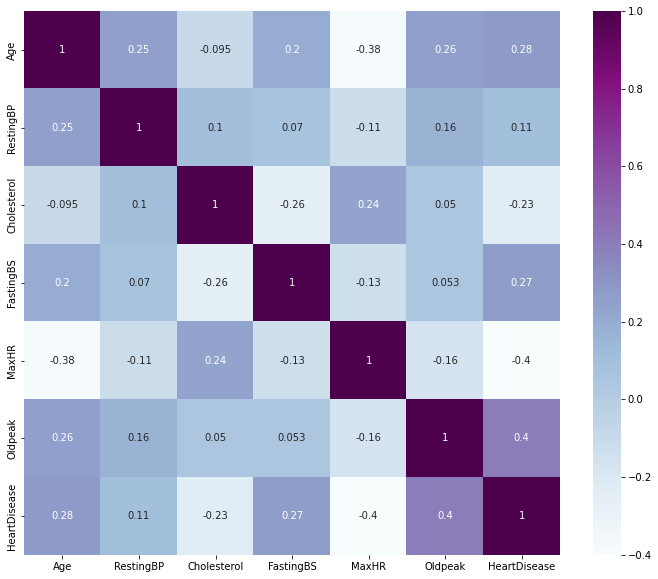

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True, cmap='BuPu');

Oldpeak y MaxHR son las columnas más correlacionadas con HeartDisease (con una correlación de 0.4 y -0.4 correspondientemente) por lo que querremos luego incluirlas en nuestro modelo.

Age, FastingBS y Cholesterol, con correlaciones de entre 0.2 y 0.3, parecen tener también influencia en HeartDisease aunque mucho menor, mientras que RestingBP teniendo una correlación de 0.11 pareciera influir realmente poco.

Parece haber cierta dependencia entre Age y MaxHr (-0.38 de coeficiente de correlación) pero al no ser alta (menor a 50%) vamos a asumirlas independientes y utilizar ambas variables en nuestro modelo.

Podemos hacer además un pairplot para observar con más detenimiento las distribuciones.

<Figure size 1080x1080 with 0 Axes>

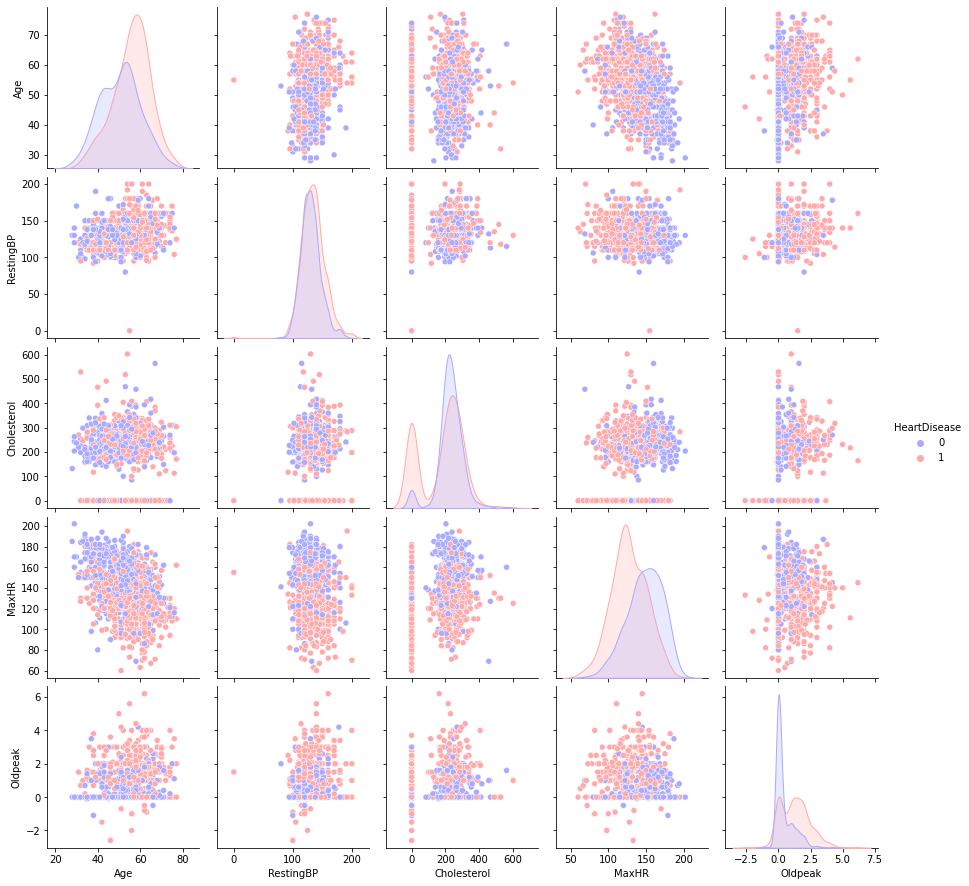

In [ ]:
plt.figure(figsize=(15,15))
sns.pairplot(df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']],hue='HeartDisease', palette='bwr');

Se puede evidenciar nuevamente la correlación negativa para Age y MaxHR.

Cholesterol y Oldpeak tienen una distribución no normal pero puede deberse a outliers. Trabajaremos con eso en la siguiente sección. 

Nos resta analizar la correlación entre las variables categóricas y HeartDisease. Para eso utilizaremos barplots, pero dado que puede ocurrir que tengamos más datos de una categoría que de otra en nuestro dataset (por ejemplo, más varones que mujeres) vamos a normalizar primero nuestros datos.

Text(0.5, 1.05, 'Porcentaje de personas con cardiopatías por cada variable - 0:No, 1:Sí')

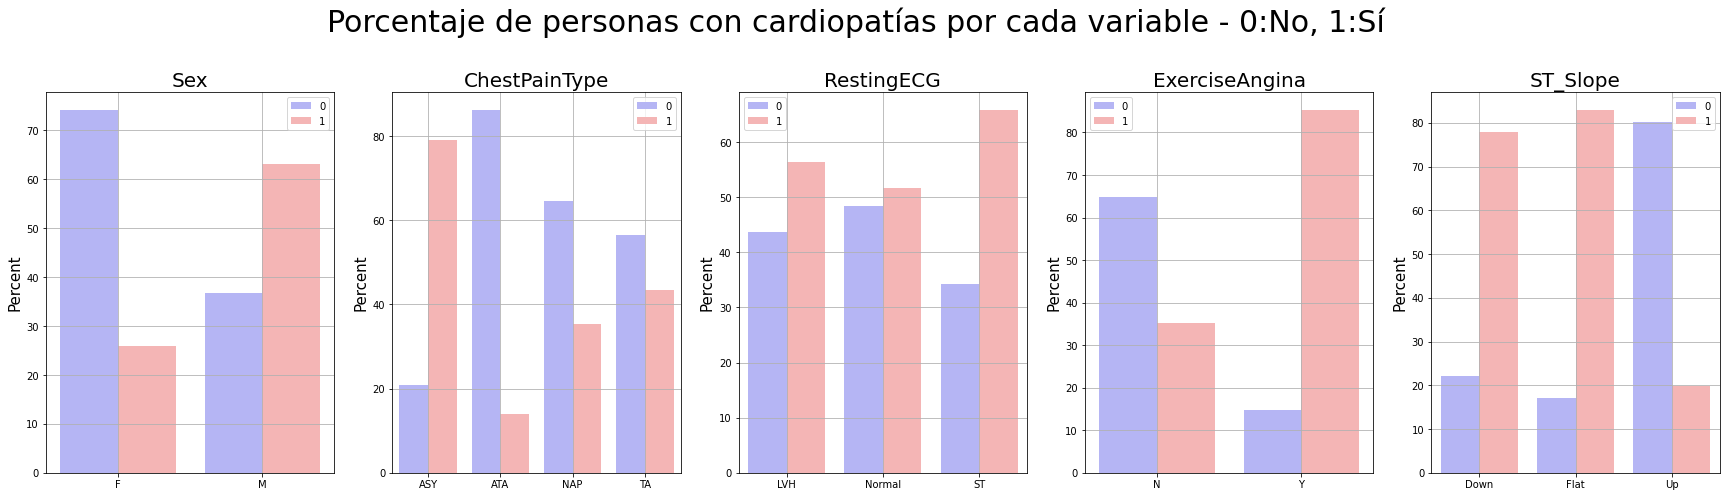

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(30, 7))
indexes = list(range(5))
col_dict = {indexes[i]: list(string_col)[i] for i in indexes}
for index, col in col_dict.items():
    df1=df.groupby(col)['HeartDisease'].value_counts(normalize=True)
    df1=df1.mul(100)
    df1=df1.rename('Percent').reset_index()
    sns.barplot(x=col, y='Percent',hue='HeartDisease', data=df1, ax=axes[index], palette='bwr');
    axes[index].set_xlabel('', fontsize=15)
    axes[index].set_ylabel('Percent', fontsize=15)
    axes[index].grid()
    axes[index].legend()
    axes[index].set_title(col, fontsize=20)
fig.suptitle('Porcentaje de personas con cardiopatías por cada variable - 0:No, 1:Sí', fontsize=30, y=1.05)

* Sex: El porcentaje de mujeres que presentaron cardiopatías es menor que el de las mujeres que sí las presentaron, mientras que en el caso de los varones podemos observar una relación inversa. Esta variable entonces parece estar correlacionada con tener o no una cardiopatía.

* ChestPainType: ASY parece estar correlacionado con tener una cardiopatía.

* RestingECG: En todas las categorías hay mayor porcentaje de individuos que luego presentaron una cardiopatía, pero en el caso de ST es mucho mayor. ST puede estar indicando la presencia de una cardiopatía.

* ExerciseAngina: El 85% de los casos en los que estuvo presente se correspondió con una cardiopatía, mientras que solo el 35% en los que no estuvo no se correspondió con una cardiopatía. Parece ser un claro indicador de HeartDisease.

* ST_Slope: Down y Flat se corresponden en un alto porcentaje con una cardiopatía, mientras que Up se corresponde en un alto porcentaje con la ausencia de una cardiopatía. Es una variable que nos va a interesar.

Antes de proceder a elegir un modelo de clasificación e implementarlo, veamos si nuestro dataset está balanceado, es decir, si tenemos una cantidad similar de personas con cardiopatías y sin cardiopatías.

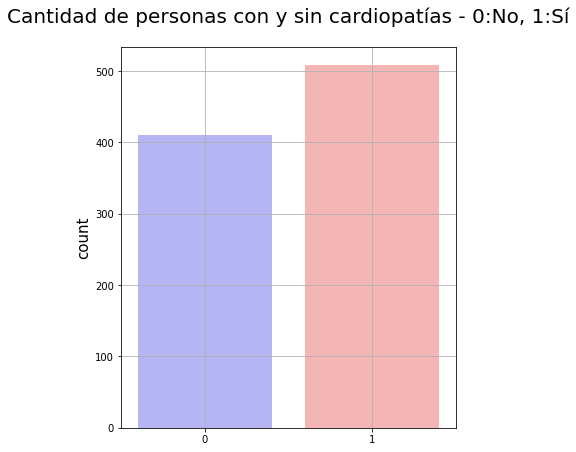

In [ ]:
plt.figure(figsize=(6, 7))
sns.countplot(x='HeartDisease', data=df, palette='bwr')
plt.xlabel('')
plt.ylabel('count', fontsize=15)
plt.title('Cantidad de personas con y sin cardiopatías - 0:No, 1:Sí', fontsize=20, y=1.05)
plt.grid()
plt.show()

Contando con algo más de 400 personas sin cardiopatías y 500 personas con cardiopatías, podemos considerar nuestro dataset balanceado.

Chequeemos si hay datos faltantes (NaN).

In [ ]:
df.isnull().values.any()

False

No tenemos datos faltantes así que no deberemos lidiar con ellos. Chequeemos ahora si existen outliers en nuestro dataset utilizando boxplots.

Vamos a chequear outliers en las variables numéricas no booleanas: Age, RestingBP, Cholesterol, MaxHR y Oldpeak.

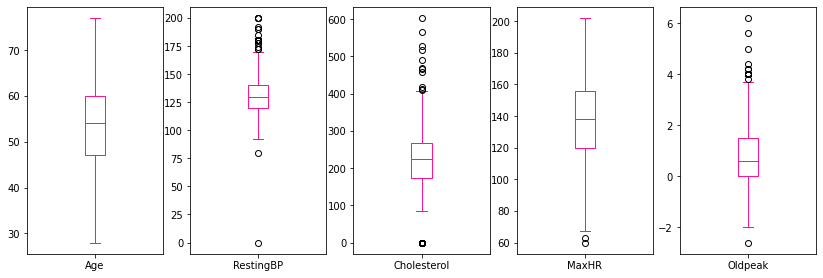

In [ ]:
num_col = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[list(num_col)].plot(kind='box', subplots=True, layout=(2,7),
sharex=False,sharey=False, figsize=(20, 10), 
color='deeppink');

Podemos apreciar que RestingBP, Cholesterol, MaxHR y Oldpeak tienen outliers.

Chequeemos qué ocurre en cada columna con mayor cuidado. Para eso definamos una función que nos ayude a chequear con mayor precisión los outliers.

In [ ]:
def check_outliers(df, cols, store=False):
    """
    La función toma un dataframe, una lista de columnas y un booleano store.
    Si store=False, solo imprime la cantidad de outliers que hay en cada columna de la lista.
    Si store=True, devuelve un diccionario que tiene como claves los nombres de las
    columnas y como valores los outliers de cada una de ellas.
    
    Parameters
    ----------
    df: Dataframe
    cols: list
    store: bool
    
    Returns
    -------
    Si store=True:
        dict_outliers: dict
    """
    dict_outliers=dict()
    for cat in cols:
        df_cat = df[cat]
        Q1 = df_cat.quantile(0.25) # 1er cuartil
        Q3 = df_cat.quantile(0.75)# 2do cuartil
        IQR = Q3-Q1 # interquartile range
        outlier_step = IQR * 1.5 
        outliers = df_cat[~((df_cat >= Q1 - outlier_step) & (df_cat <= Q3 + outlier_step))].index.tolist()  
        dict_outliers[cat]=outliers
        if not store:
            print('Para la variable {} hay {} outliers'.format(cat, len(outliers)))
    if store:
        return dict_outliers

In [ ]:
check_outliers(df, num_col)

Para la variable Age hay 0 outliers
Para la variable RestingBP hay 28 outliers
Para la variable Cholesterol hay 183 outliers
Para la variable MaxHR hay 2 outliers
Para la variable Oldpeak hay 16 outliers


En RestingBP, MaxHR y Oldpeak la cantidad de outliers es muy pequeña pero en Cholesterol es una cantidad considerable. En ese caso se podría optar por no utilizar esa columna para el modelo en vez de remover los outliers, cambiar la constante por la que se multiplica el IQR, reemplazar los outliers por algún valor apropiado o alguna combinación de estos últimos.

Vamos a optar por remover los outliers igualmente en todas las columnas, ver si el dataset sigue quedando balanceado y la cantidad de datos restantes.

In [ ]:
def remove_outliers(df, cols):
    """
    La función toma un dataframe y una lista de columnas.
    Droppea los outliers del dataframe en esas columnas.
    
    Parameters
    ----------
    df: Dataframe
    cols: list
    """
    outliers = check_outliers(df, num_col, store=True)
    for cat in cols:
        df.drop(outliers[cat], inplace = True, errors = 'ignore')

In [ ]:
remove_outliers(df, num_col)

Chequeamos que los datos hayan quedado balanceados.

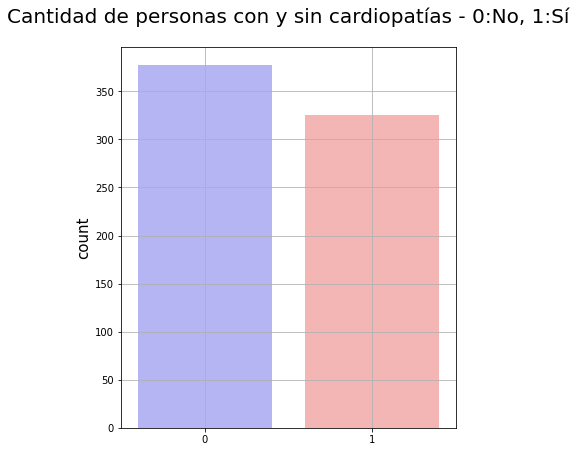

In [ ]:
plt.figure(figsize=(6, 7))
sns.countplot(x='HeartDisease', data=df, palette='bwr')
plt.xlabel('')
plt.ylabel('count', fontsize=15)
plt.title('Cantidad de personas con y sin cardiopatías - 0:No, 1:Sí', fontsize=20, y=1.05)
plt.grid()
plt.show()

Chequeamos la cantidad de datos.

In [ ]:
df.shape

(702, 12)

Miremos las correlaciones y distribuciones.

<Figure size 1080x1080 with 0 Axes>

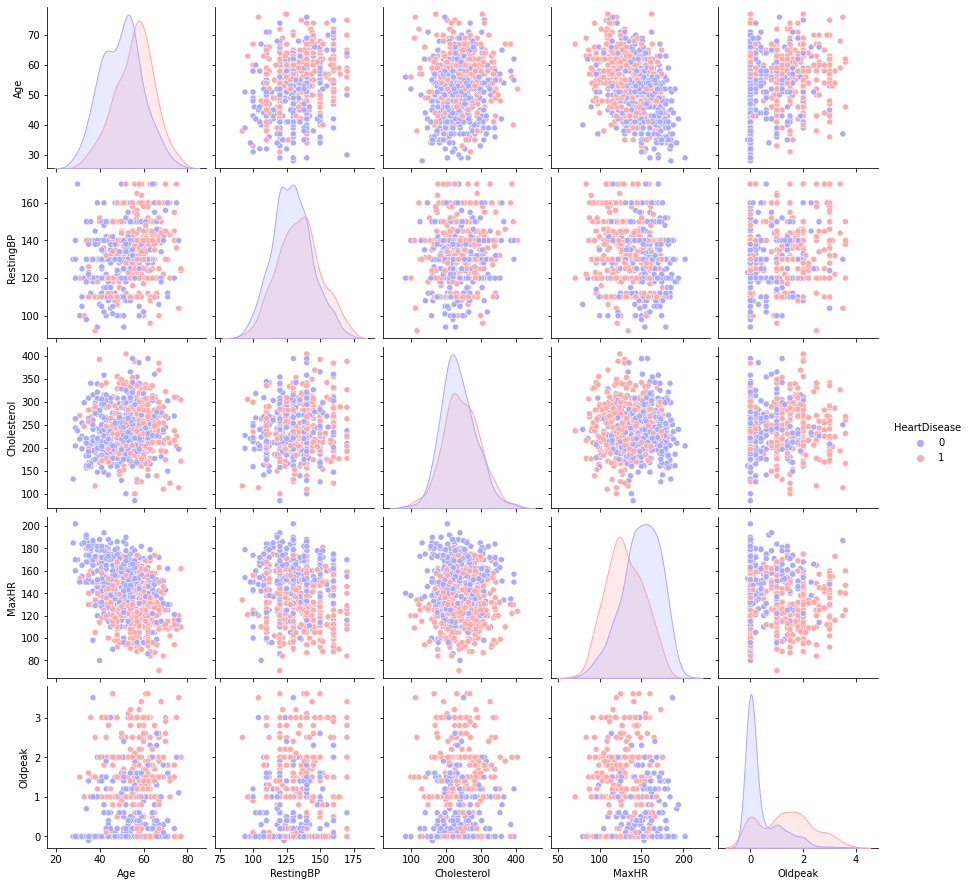

In [ ]:
plt.figure(figsize=(15,15))
sns.pairplot(df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']],hue='HeartDisease', palette='bwr');

El dataset está balanceado y seguimos teniendo 702 datos. Podemos apreciar además que al remover los outliers todas las distribuciones quedaron más similares a una normal.

Considerando lo observado en la sección anterior, se ha decidido utilizar las siguientes columnas:
* Oldpeak
* MaxHR
* Age
* FastingBS
* Cholesterol
* Sex
* ChestPainType
* RestingECG
* ExerciseAngina
* ST_Slope

In [ ]:
df = df.drop(columns=['RestingBP']) # droppeamos RestingBP porque no la vamos a considerar para entrenar nuestro modelo

## 3. Implementación del modelo predictivo <a id='modelo'></a> 

En esta sección procederemos a elegir, inicializar e implementar un modelo de clasificación que nos permita determinar si un paciente tendrá una cardiopatía o no.

Como no hay valores faltantes y podemos considerar que no hay una dependencia fuerte entre las variables a considerar para entrenar el modelo, procederemos a utilizar un modelo de regresión logística.

Vamos a empezar separando en X e y (target).

In [ ]:
y = df.HeartDisease.values # seleccionamos solo la columna HeartDisease para y que será nuestro target
X = df.drop(columns=['HeartDisease']) # dejamos el resto de las columnas en X

Separemos nuestros datasets en train (entrenamiento) y test (evaluación). Vamos a utilizar un 80% de los datos para entrenamiento y el 20% restante para evaluación. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 1)

Chequeemos que luego del split nuestros datasets hayan quedado balanceados. Para eso podemos ver el porcentaje de casos con cardiopatías que hay en y_train e y_test.

In [ ]:
print('Porcentaje de cardiopatías')
print('y_train:', np.count_nonzero(y_train == 1)/len(y_train))
print('y_test:', np.count_nonzero(y_test == 1)/len(y_test))

Porcentaje de cardiopatías
y_train: 0.46345811051693403
y_test: 0.46099290780141844


Ahora que corroboramos que tenemos balanceados nuestros datos, podemos proceder.

Como vamos a usar regresión logística deberemos crear dummy variables a partir de las variables categóricas en vez de utilizar esas variables directamente. Para eso vamos a realizar One Hot Encoding.

In [ ]:
cats = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
encoder = OneHotEncoder(drop="first")  # aprendo las dummies de train
cats_train = encoder.fit_transform(X_train[cats]).toarray()

print(encoder.get_feature_names())  # por las dudas chequeamos
cats_test = encoder.transform(X_test[cats]).toarray()  # no fit, ya aprendi el parámetro

['x0_M' 'x1_ATA' 'x1_NAP' 'x1_TA' 'x2_Normal' 'x2_ST' 'x3_Y' 'x4_Flat'
 'x4_Up']


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Ahora estandaricemos nuestros datos de entrenamiento.

In [ ]:
nums = list(set(X_train.columns) - set(cats)) # obtenemos solo las columnas con variables numéricas
scaler = StandardScaler() # setteamos el scaler

# estandarizamos
nums_train = scaler.fit_transform(X_train[nums]) # estandarizamos train
nums_test = scaler.fit_transform(X_test[nums]) # estandarizamos test

# creamos los train y test set finales con todas las columnas categóricas y numéricas
X_train_final = np.concatenate([nums_train, cats_train], axis=1)
X_test_final = np.concatenate([nums_test, cats_test], axis=1)

Ya tenemos todo el preprocesamiento de datos, continuemos con nuestro modelo. Como dijimos previamente, optamos por utilizar regresión logística.

In [ ]:
LogisticRegressionModel = LogisticRegression(penalty='l2',solver='sag',C=1.0,random_state=32) # inicializamos
LogisticRegressionModel.fit(X_train_final, y_train) # entrenamos
y_pred = LogisticRegressionModel.predict(X_test_final)  # generamos nuestras predicciones

## 4. Evaluación del modelo <a id='evaluacion'></a> 

En esta sección procederemos a analizar algunas métricas para ver qué tan bueno resultó nuestro modelo.

Veamos ahora el score de nuestro modelo para evaluar qué tan bien está realizando las predicciones.

In [ ]:
print('LogisticRegressionModel Test Accuracy Score is:', LogisticRegressionModel.score(X_test_final, y_test))

LogisticRegressionModel Test Accuracy Score is: 0.8936170212765957


Obtuvimos un 89.4% lo cual quiere decir que las predicciones de nuestro modelo se ajustan bastante bien.

Dado el contexto de este dataset, nos va a interesar además ver el recall score.

In [ ]:
from sklearn.metrics import recall_score
print('LogisticRegressionModel Test Recall is:', recall_score(y_test,y_pred))

LogisticRegressionModel Test Recall is: 0.9384615384615385


Con un recall de 93.8%, podemos realmente afirmar que es un buen modelo.